In [159]:
from IPython.core.display import SVG
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

See on lihtne näide, kuidas ise närvivõrku teha ning kuidas see toimib. Aluseks on võetud see artikkel: https://iamtrask.github.io/2015/07/12/basic-python-network/. Et kood töötaks, on vaja pakette jupyter notebook, matplotlib, numpy, pandas.

## Närvivõrk

Närvivõrk on üks (populaarne) lähenemisi masinõppes. Tema võlu seisneb selles, et teoreetiliselt peaks ta suutma õppida ära väga keerulisi mustreid. Närvivõrke saab kasutada objektide tuvastamiseks piltidelt, videodelt, tekstide klassifitseerimiseks ja paljude muude ülesannete täitmiseks.

Käesolev näide on väga lihtne, mis näitab närvivõrgu kõige olulisemaid toimimise põhimõtteid.

## Arhitektuur

Arhitektuur tähendab käesolevas töös ülesehitust. Närvivõrgu ülesehitus ühes lihtsaimas vormis on alltoodud joonisel (allikas By Glosser.ca - Own work, Derivative of File:Artificial neural network.svg, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=24913461).

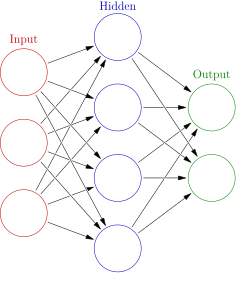

In [160]:
SVG(filename='figures/Colored_neural_network.svg')

Erinevate värvidega on erinevad kihid ("layers"):
- punasega ("input") sisendkiht
- sinisega peidetud ("hidden") kiht
- rohelisega ("output") väljundkiht

Nooled näitavad ühendusi kihtide vahel. Meie kasutame aga veelgi lihtsamat arhitektuuri, kus peidetud kihti ei ole:

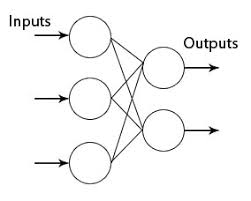

In [161]:
display(Image.open('figures/no_hidden.jpg'))

Sisendkihist liigutakse otse väljundkihti. Kohe sellest lähemalt.

## Andmed

#### Sisend

Alustame sisendandmetest. Meil on neli lauset, mille abil tahame treenida mudeli, mis suudaks uute (seni tundmatute) lausete tonaalsust hinnata:
- "see on halb"
- "on mitte väga hea"
- "on nii tore"
- "on väga tore"

Mudel vajab sisendiks andmeid aga numbrilisel kujul. Meie teeme sisendandmete jaoks 3 muutujat (veergu):
- kas lause sisaldab sõna "tore"
- kas lause sisaldab sõna "väga"
- kas lause sisaldab sõna "on"
Esitleme tulemuse maatriksina (õigemini numpy array'na) (veergudes on muutujad, ridades laused. Kui lause sisaldab sõna, on 1, vastasel juhul 0):

In [162]:
X = np.array([[0,0,1],
              [0,1,1],
              [1,0,1],
              [1,1,1]]) 
X

array([[0, 0, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 1]])

Esimeses lauses on ("see on halb") on sõna "on", mistõttu on ainult kolmandas veerus 1 ja teistes 0. NB! seda näide on lihtsustus, tavaliselt tehakse kõikide unikaalsete sõnade kohta oma muutuja (veerg), meie tegime lihtsuse mõttes ainult 3.

Praegu moodustasime sisendandmestiku käsitsi, tegelikult saaks seda teha pythonis programmiga, kus sisendiks oleks list lausetest laused =["see on halb","on väga halb","on nii tore", "on mitte väga tore"]. See aga jääb koduseks/edasiseks pähkliks, mida pureda :)

#### Väljund

Õigeks väljundiks on iga lause tonaalsus (positiivne=1/negatiivne=0). Seegi on numpy array kujul:

In [163]:
y = np.array([[0,0,1,1]]).T #T transponeerib, ehk pöörab array ümber et meil oleks ühe rea asemel üks veerg
y

array([[0],
       [0],
       [1],
       [1]])

Nagu väljundist näha on esimesed kaks lauset negatiivsed ning kaks viimast negatiivsed. Andmed on olemas, nüüd jääb üle luua mudel, mis suudaks sisendmuutujate (veergude) abil öelda, kas lause on positiivne või negatiivne.

## Mudel

#### Treenimine (kood)

Esmalt näitan ära, kuidas mudelit treenida, siis selgitan lähemalt iga koodijupi sisu. Üldjoontes, mida me teeme:
- võtame sisendiks oma array ja korrutame mudeli kaaludega, saame mudeli väljundi (liigume joonisel sisendkihist väljundkihti)
- leiame kui palju mudel eksis võrreldes tegeliku tonaalsusega igas lauses
- võtame tuletise, et leida, kui palju iga kaal mudeli lõplikku veasse panustas
- uuendame tuletise ja vea skalaarkorrutise võrra kaale, et mudel oleks järgmine kord täpsem
- kordame kogu protsessi mitu korda

Ühe märkusena ütlen, et meie mudel on veel lihtsam, kui üleval toodud joonis, meie mudelil pole peidetud kihti (on ainult sisend ja väljundkiht).

In [164]:
#sigmoidfunktsioon, sellest varsti lähemalt
def sigmoid(x):
    return 1/(1+np.exp(-x))

#sigmoidfunktsiooni tuletis, sellestki hiljem
def sigmoid_der(x):
    return x*(1-x)

#kuna kasutame juhuslikkust, ütleme, seame seedi see tagab, et pärast saame sama tulemuse
#kui see välja kommenteerida, on iga kord tulemused veidi erinevad
np.random.seed(1)

#väärtustame mudeli kaalud (weights), mida pärast hakkame muutma, et mudel oleks täpsem.
#lihtsalt anname juhuslikud väärtused, mille keskmine väärtus on 0
syn0 = 2*np.random.random((3,1)) - 1

#treenime, lastes andmed mudelist 60000x läbi
for i in range(60000):
    #l0 on kiht (layer) 0, meie puhul sisendkiht, annam väärtuseks sisendi, array Xi
    l0 = X
    
    #laseme andmed mudelist läbi, ehk teeme maatrikskorrutuse (dot-product) 
    #ning laseme läbi sigmoidfunktsiooni
    l1 = sigmoid(l0@syn0)
    #kui ülemine rida annab errorit siis proovi seda
    #l1 = sigmoid(np.dot(l0,syn0))

    # arvutame mudeli tulemuse ja tegeliku tulemuse vahe
    l1_error = y - l1
    
    #arvutame välja kui palju me peaks iga mudeli kaalu (syn0) väärtust muutma, et mudel oleks parem
    #selleks võtame tuletise (kuidas seda võetakse, pole väga oluline) ja korrutame läbi veaga
    #sellega saame teada, kui palju me peaks igat kaalu uuendama
    l1_delta =l1_error * sigmoid_der(l1)
    
    # korrigeerime mudeli kaalusid (syn0), "põrgatame" vea tagasi, et järgmine ring oleks mudel täpsem
    syn0 +=l0.T@l1_delta
    #kui eelnev rida annab errori proovi seda
    #syn0 += np.dot(l0.T,l1_delta)

Vaatame lõpuks treenitud mudeli väljundit

In [165]:
l1

array([[0.00390234],
       [0.00318168],
       [0.99740397],
       [0.99681554]])

tegelik (õige) väljund on:

In [166]:
y

array([[0],
       [0],
       [1],
       [1]])

On näha, et seal, kus lause õige emotsioon on negatiivne, on tulemus madalam (0 lähemal) ning seal, kus lause õige emotsioon on positiivne, on tulemus kõrgem (1 lähemal). Mudel õppis!

Nüüd võtama asjad veidi teravama luubi alla.

#### Skalaarkorrutis (dot-product)

Me kasutame paaris kohas skalaarkorrutist.

Selle müstilise asja taga on lihtne loogika. Me võtame kaks maatriksit (meie puhul array'd):

In [167]:
l0

array([[0, 0, 1],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 1]])

In [168]:
syn0

array([[11.49345763],
       [-0.2048909 ],
       [-5.54227641]])

ning saame tulemuse:

In [169]:
l0 @ syn0

array([[-5.54227641],
       [-5.74716731],
       [ 5.95118122],
       [ 5.74629032]])

Tulemus saadi selliste arvutustega:

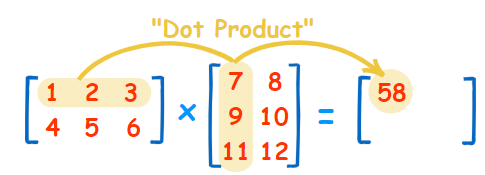

In [170]:
display(Image.open('figures/dot1.PNG'))

Meie näites 0 x 11.49345763 + 0 x -0.2048909 + 1 x -5.54227641 = -5.54227641

- Teine rida meie näites on saadud sedasi:  0 x 11.49345763 + 1 x -0.2048909 + 1 x -5.54227641 = -5.74716731
- Kolmas rida:  1 x 11.49345763 + 0 x -0.2048909 + 1 x -5.54227641 = 5.95118122
- Neljas rida:  1 x 11.49345763 + 1 x -0.2048909 + 1 x -5.54227641 = 5.74629032

Meie jaoks on olemas ilus funktsioon, mis teeb selle meie eest. Oluline aspekt, mida jälgida on, et esimesel maatriksil oleks sama palju veerge kui teisel maatriksil on ridu (selle tõttu loome ainult kolm kaalu mudelile).

#### Sigmoidfunktsioon

Teine uus asi on sigmoidfunktsioon. Tegelikult ei pea me kasutama sigmoidfunktsiooni, kuid see on levinud närvivõrkudes. Sigmoidfunktsioon aitab mudelil olla mittelineaarne (õppida keerukaid mustreid) ning piirata, et mudeli väljund ei ole liiga suure väärtusega. Funktsioon ise oli selline:

In [171]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

Selleks, et sigmoidfunktsiooni hingeelust veidi rohkem aimu saada, vaatame seda joonisel

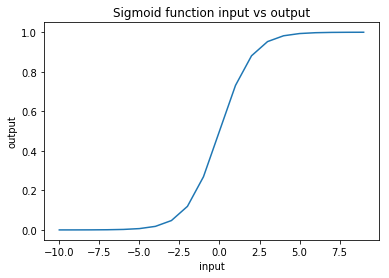

In [172]:
df_sigmoid=pd.DataFrame.from_dict({'x':[x for x in range(-10,10)]})
df_sigmoid=df_sigmoid.set_index(df_sigmoid.x)
df_sigmoid['sig']=sigmoid(df_sigmoid.x)
plt_sig=df_sigmoid.sig.plot(title='Sigmoid function input vs output')
plt_sig.set_xlabel('input')
plt_sig.set_ylabel('output')

Joonisel on näha funktsiooni sisend (parameeter x) ning väljund. Me näeme, et mida väiksem on sisend, seda väiksem on ka väljund. Mida suurem on sisend, seda suurem on väljund. __Funktsiooni kõik väljundid on 0 ja 1 vahel__. Sigmoidfunktsioon aitab mudelil arvutada, kui palju sisse tulnud infost peaks edasi andma (väga madal sisendväärtus tekitab väikese väljundväärtuse ja vastupidi) ning normaliseerib väljundit (see on 0 ja 1 vahel, mitte ei ole näiteks miljonites). Selline normaliseerimine aitab arvutitel teha lihtsamini arvutusi, kuna liiga suured või väikesed numbrid võivad tekitada probleeme.

#### Sigmoidfunktsiooni tuletis

Sigmoidfunktsiooni tuletise leidmine pole käesoleva kirjatüki teema (selle kohta võib lugeda siit: https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e)

Küll aga on oluline aru saada tuletise sisust. Tuletis on tõus graafikul. Joonisel märkisin tõusu kolmes kohas (kahes rohelise ja ühes punasega):

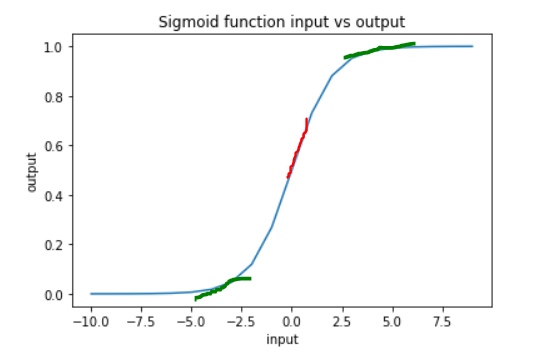

In [173]:
display(Image.open('figures/derivative.PNG'))

Rohelistest kohtades on tõus(-u nurk) madalam kui punases. Seal, kus tõus on kõrgem, seal on ka funktsiooni tuletise väärtus suurem ning meie mudel ei ole sellistes punktides kindel (kas lause on positiivne või negatiivne). Selle tõttu peame sellistes punktides mudeli kaale ka rohkem uuendama.

Kui vaatame mudeli lõplikku tulemust, on näha, et mudel on päris hästi suutnud eristada positiivsed ja negatiivsed laused:

In [174]:
l1

array([[0.00390234],
       [0.00318168],
       [0.99740397],
       [0.99681554]])

#### Treenimine (koos pildi ja koodiga)

Nüüd, kus asi on piisavalt ebaselge, näitan, mida kood teeb graafliselt.

##### 0. Kaalude algsete väärtuste seadmine

Me seadsime mudelile algselt kaalud sedasi (tulemuseks on array):

In [175]:
syn0 = 2*np.random.random((3,1)) - 1
syn0

array([[-0.39533485],
       [-0.70648822],
       [-0.81532281]])

Oluline on kaalud seada juhuslikult, see aitab mudelil kiiremini õppida. Joonisel on kaalud ühendused sisend- ja väljundkihi vahel:

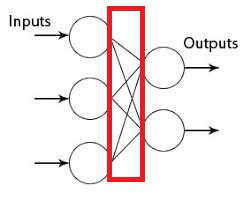

In [176]:
display(Image.open('figures/no_hidden2.jpg'))

Need kaalud ongi mudel, eesmärk on saada sellised kaalud, mis sisendandmete puhul annaks võimalikult täpse tulemuse. Mudeli treenimine ongi parimate kaalude leidmine.

##### 1. Sisendkihi väärtustamine

Siin lihtsalt deklareerime, et sisendkihi väärtused tulevad muutujast X (meie lausetest tehtud muutujad)

In [177]:
l0 = X

In [187]:
l0==X #X ja l0 väärtused on võrdsed?

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

Joonisel on see esimene veerg mummusid:

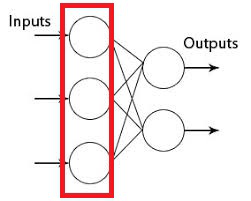

In [179]:
display(Image.open('figures/no_hidden1.jpg'))

##### 2. Väljundi arvutamine

Nüüd, kus meil on sisendkihi ja kaalude väärtused olemas, saame arvutada väljundi. Esmalt arvutame skalaarkorrutise sisendi ja mudeli kaalude vahel. Seejärel kasutame sigmoidfunktsiooni, mis tagab, et väljund on 0 ja 1 vahel:

In [180]:
sigmoid(l0@syn0)

array([[0.3067574 ],
       [0.17919499],
       [0.22958471],
       [0.12818018]])

Joonisel liigume väljundkihi poole kasutades eelmiste kihtide väärtusi.

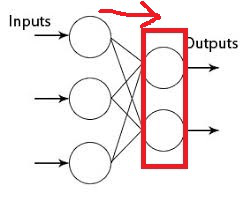

In [181]:
display(Image.open('figures/no_hidden3.jpg'))

##### 3. Vea suuruse leidmine

Pärast mudeli väljundi saamist, saame võrrelda, kui täppi mudel pani võrreldes lausete tegelike tonaalsustega:

In [182]:
l1_error = y - l1
l1_error

array([[-0.00390234],
       [-0.00318168],
       [ 0.00259603],
       [ 0.00318446]])

##### 4. Iga kaalu panuse leidmine veasse

Nüüd, kus teame viga, saame sigmoidfunktsiooni tuletist kasutades leida, kui palju iga kaal panustas konkreetse lause veasse. Selleks võtame väljundist tuletise ning korrutame veaga:

In [183]:
l1_delta =l1_error * sigmoid_der(l1)
l1_delta

array([[-1.51688604e-05],
       [-1.00908847e-05],
       [ 6.72187213e-06],
       [ 1.01085148e-05]])

Kui viga on väike, siis ei pea me kaale palju uuendama, kui viga on suur (tuletis on suur), siis peame kaale rohkem uuendama. Tuletise osa võib olla keeruline, kuid oluline on mõista selle sisu, kui seda, kuidas seda konkreetselt arvutatakse. Tuletis aitab meil leida iga kaalu panust lõpptulemusse. Korrutades selle läbi veaga, leiam, kui palju iga kaal panustas lõplikku veasse.

Selle osa arvutuse tulemusel saame teada, kui palju tuleks kaale uuendada, et mudel oleks täpsem.

##### 5. Kaalude uuendamine

Nüüd, kus teama, kui palju kaalusid uuendada, saame seda ka lõpuks teha. Kasutame jällegi skalaarkorrutist (korrutame sisendkihi pööratud array (et skalaarkorrutises oleks esimese array veergude ja teise ridade arv vastavuses) ning iga kaalu panuse veasse)

In [184]:
syn0 +=l0.T@l1_delta

In [185]:
syn0

array([[-0.39531802],
       [-0.7064882 ],
       [-0.81533124]])

Joonisel on see näha liikumisena tagasi (_backward propagation_), uuendame mudeli kaale kasutades väljundist saadud infot.

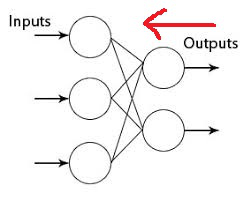

In [186]:
display(Image.open('figures/no_hidden4.jpg'))

#### Lõpetuseks

Nüüd edasi kordame sama protsessi (välja arvatud samm 0) mitu korda, et iga korraga saada veelgi paremad kaalud. Loodan, et sellest näidised on kasu.

Kindlasti ei ole see mudel ideaalne, üheks mureks on, et me kasutame mudeli täpsuse mõõtmiseks andmeid, mida mudel on näinud. See võib tähendada, et mudel on ületreenitud (overfitting). Selle kohta saab lugeda siit: https://elitedatascience.com/overfitting-in-machine-learning

Lisaks võime teha keerulisema mudeli, kus on üks või mitu peidetud kihti. Mudeli üldine loogika on selle juhul sama, lihtsalt arvutusi tuleb tea rohkem, sest meil ei ole üks kiht kaale, vaid mitu kihti.